In [1]:
!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00


In [2]:
data = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
test = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [4]:
data.isna().any()

date            False
meantemp        False
humidity        False
wind_speed      False
meanpressure    False
dtype: bool

In [5]:
test.isna().any()

date            False
meantemp        False
humidity        False
wind_speed      False
meanpressure    False
dtype: bool

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [8]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['date'] = data['date'].dt.strftime('%d-%m-%Y') 
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')

In [9]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test['date'] = data['date'].dt.strftime('%d-%m-%Y') 
test['date'] = pd.to_datetime(test['date'], format='%d-%m-%Y')

In [10]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1462,2015-01-01 12:00:00,2013-01-01 00:00:00,2014-01-01 06:00:00,2015-01-01 12:00:00,2016-01-01 18:00:00,2017-01-01 00:00:00,NaN
meantemp,1462.0,25.495521,6.0,18.857143,27.714286,31.305804,38.714286,7.348103
humidity,1462.0,60.771702,13.428571,50.375,62.625,72.21875,100.0,16.769652
wind_speed,1462.0,6.802209,0.0,3.475,6.221667,9.238235,42.22,4.561602
meanpressure,1462.0,1011.104548,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333,180.231668


In [11]:
data=data.set_index('date')
data.sample()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-06-01,36.0,42.2,9.133333,1002.733333


In [12]:
test=test.set_index('date')

In [13]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day_name'] = data.index.strftime('%A')
data

,meantemp,humidity,wind_speed,meanpressure,year,month,day_name
date,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,Tuesday
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,Wednesday
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,Thursday
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,Friday
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,Saturday
...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,Wednesday
2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,Thursday
2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,Friday


In [14]:
test['year'] = test.index.year
test['month'] = test.index.month
test['day_name'] = test.index.strftime('%A')
test

,meantemp,humidity,wind_speed,meanpressure,year,month,day_name
date,,,,,,,
2013-01-01,15.913043,85.869565,2.743478,59.000000,2013,1,Tuesday
2013-01-02,18.500000,77.222222,2.894444,1018.277778,2013,1,Wednesday
2013-01-03,17.111111,81.888889,4.016667,1018.333333,2013,1,Thursday
2013-01-04,18.700000,70.050000,4.545000,1015.700000,2013,1,Friday
2013-01-05,18.388889,74.944444,3.300000,1014.333333,2013,1,Saturday
...,...,...,...,...,...,...,...
2013-04-20,34.500000,27.500000,5.562500,998.625000,2013,4,Saturday
2013-04-21,34.250000,39.375000,6.962500,999.875000,2013,4,Sunday
2013-04-22,32.900000,40.900000,8.890000,1001.600000,2013,4,Monday


In [15]:
data.loc['2013']

,meantemp,humidity,wind_speed,meanpressure,year,month,day_name
date,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,Tuesday
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,Wednesday
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,Thursday
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,Friday
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,Saturday
...,...,...,...,...,...,...,...
2013-12-27,11.875000,79.875000,1.162500,1018.625000,2013,12,Friday
2013-12-28,10.875000,70.000000,5.325000,1019.250000,2013,12,Saturday
2013-12-29,10.571429,69.428571,5.325000,1018.500000,2013,12,Sunday


In [16]:
data.loc['2014-01-01':'2014-02-01']

,meantemp,humidity,wind_speed,meanpressure,year,month,day_name
date,,,,,,,
2014-01-01,13.375000,89.625000,7.650000,1021.000000,2014,1,Wednesday
2014-01-02,11.000000,78.375000,8.100000,1020.250000,2014,1,Thursday
2014-01-03,12.500000,74.875000,5.325000,1017.750000,2014,1,Friday
2014-01-04,12.875000,88.125000,1.162500,1016.250000,2014,1,Saturday
2014-01-05,12.375000,89.000000,0.462500,1014.500000,2014,1,Sunday
2014-01-06,11.428571,86.285714,27.337500,1017.625000,2014,1,Monday
2014-01-07,12.142857,72.285714,20.600000,1017.750000,2014,1,Tuesday
2014-01-08,11.875000,76.875000,1.850000,1017.875000,2014,1,Wednesday
2014-01-09,12.833333,83.000000,1.233333,1017.000000,2014,1,Thursday


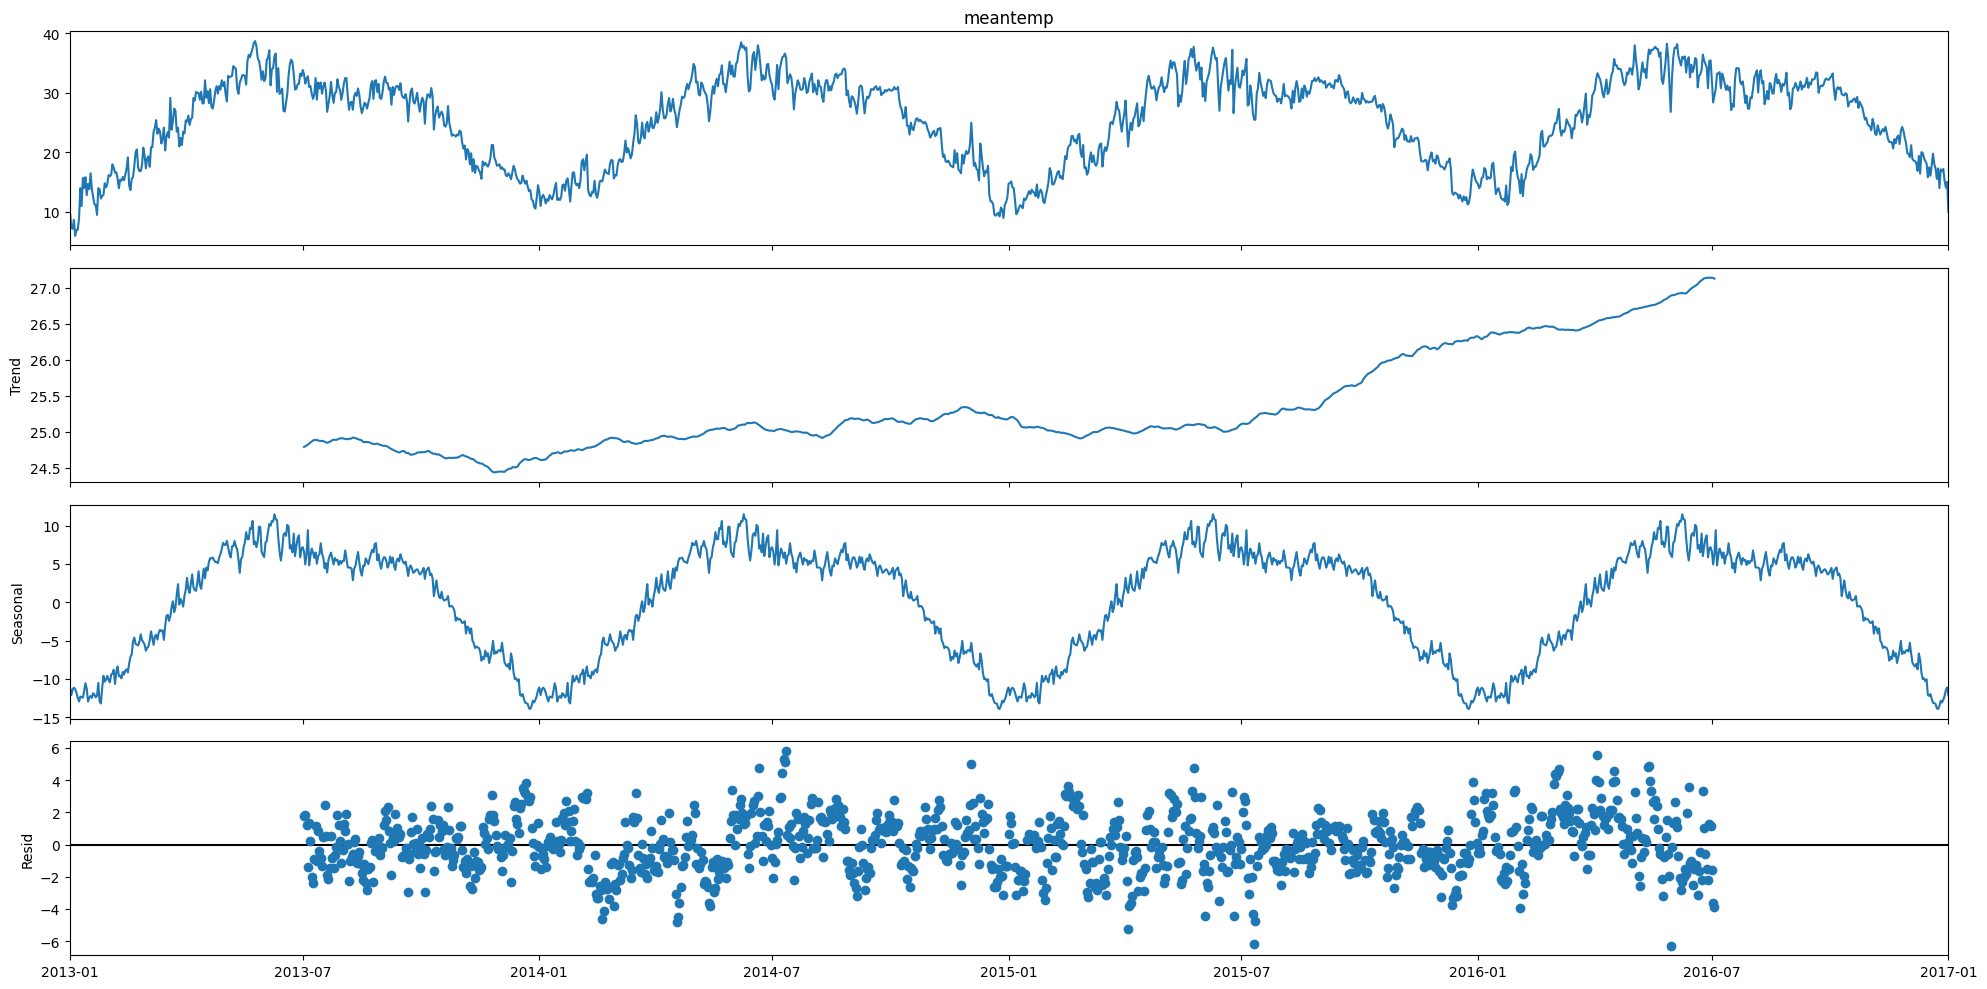

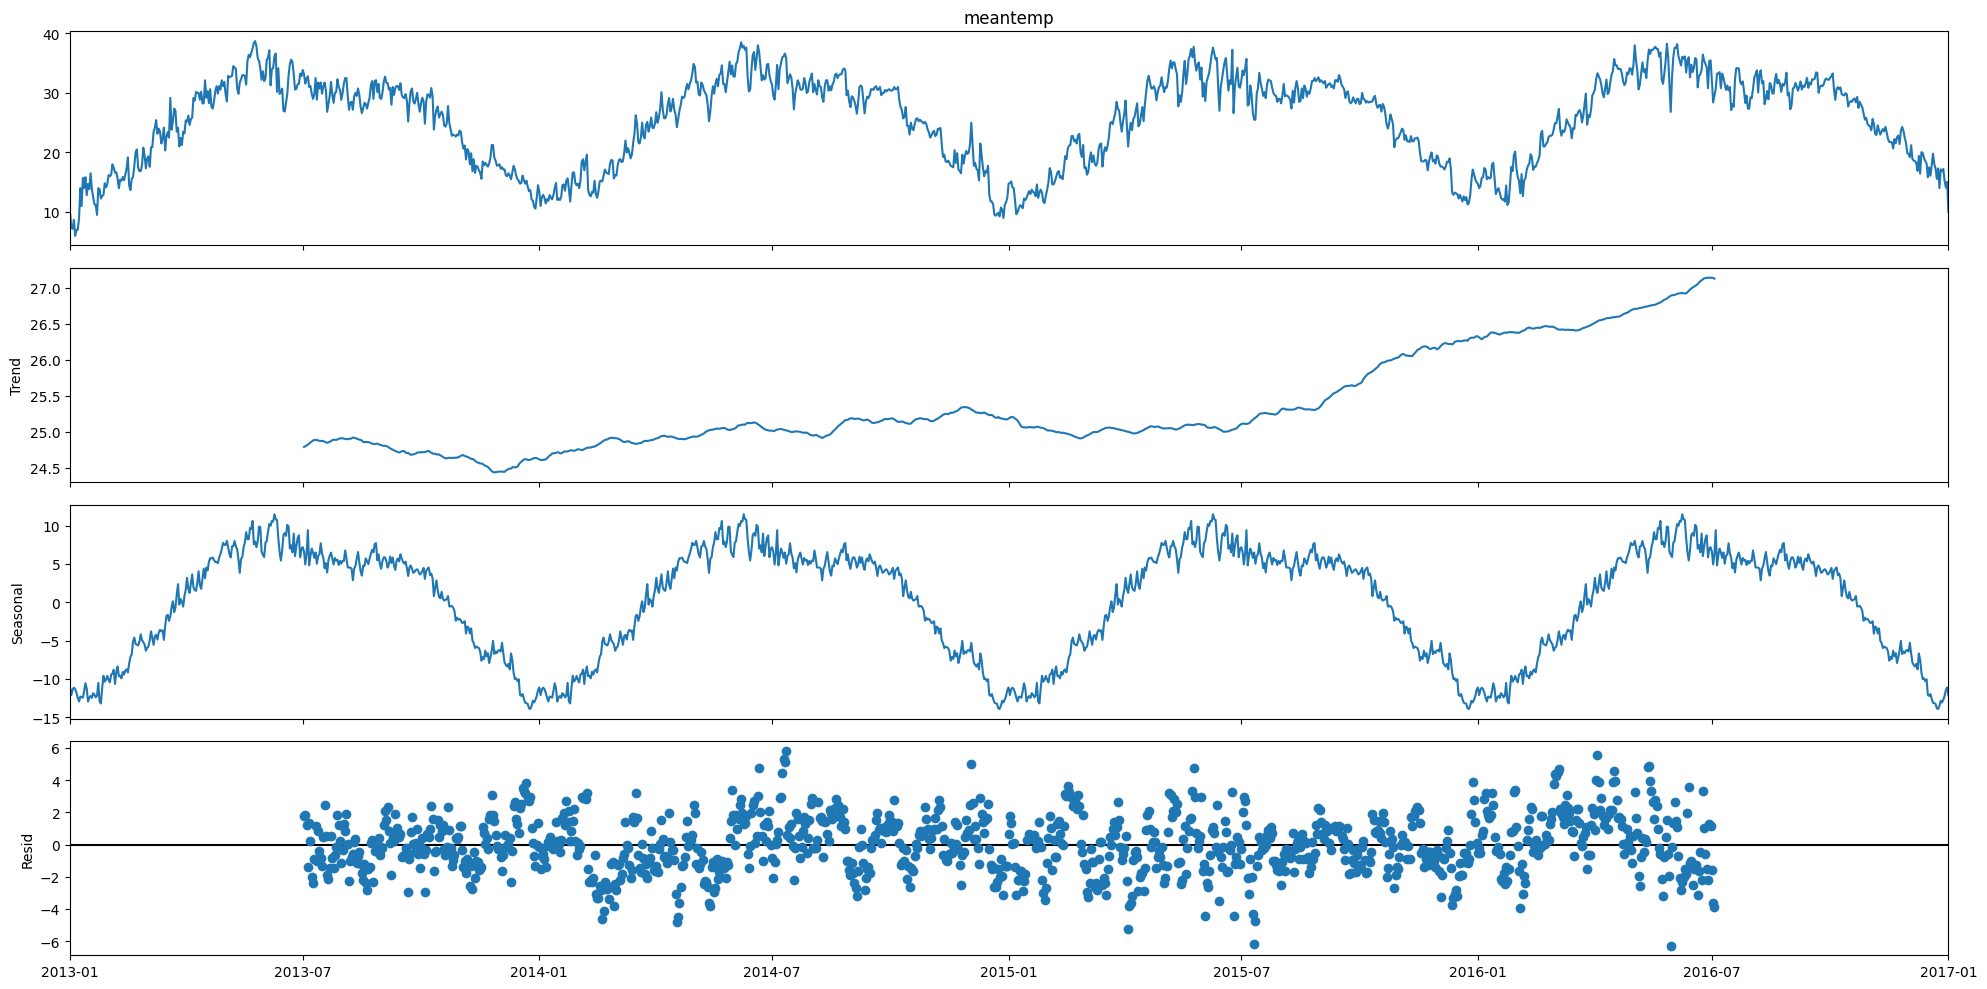

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['meantemp'], model='additive', period=365)
result.plot()

Seasonal decomposition for year 2013:


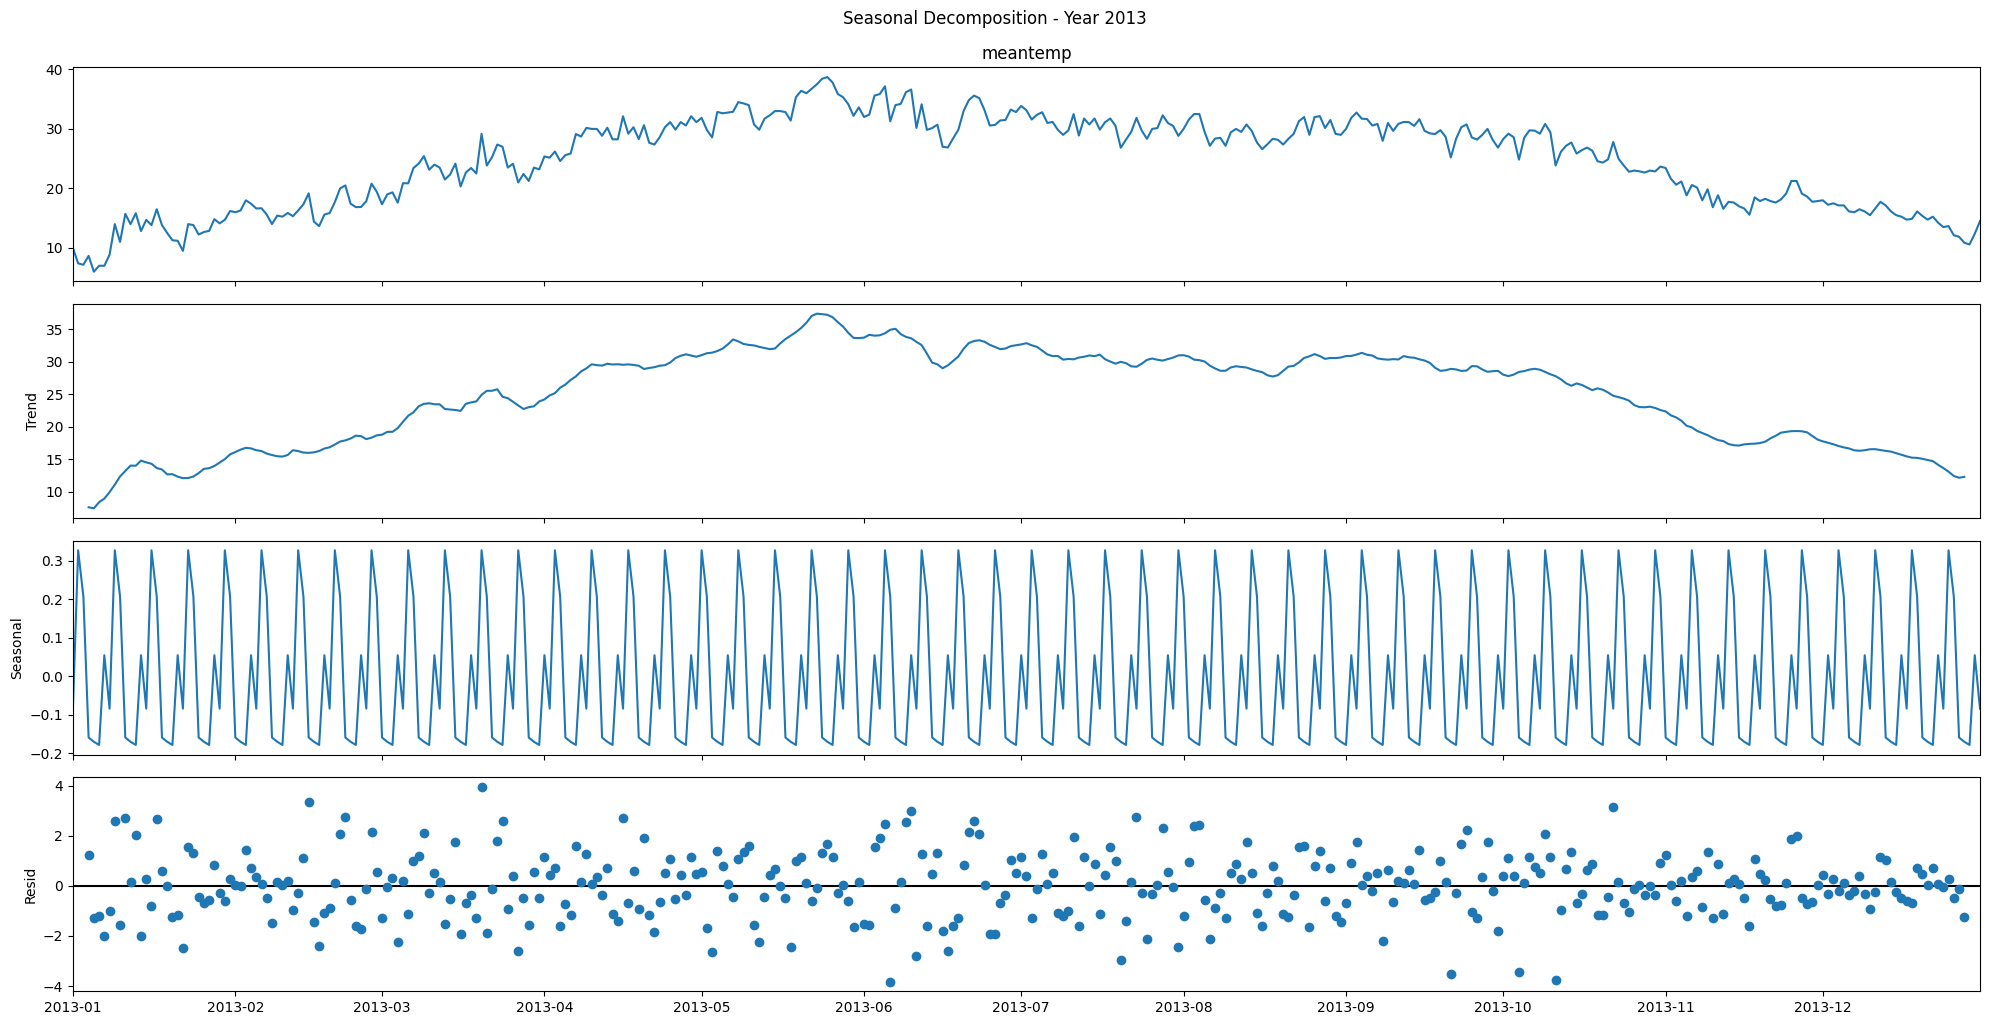

Seasonal decomposition for year 2014:


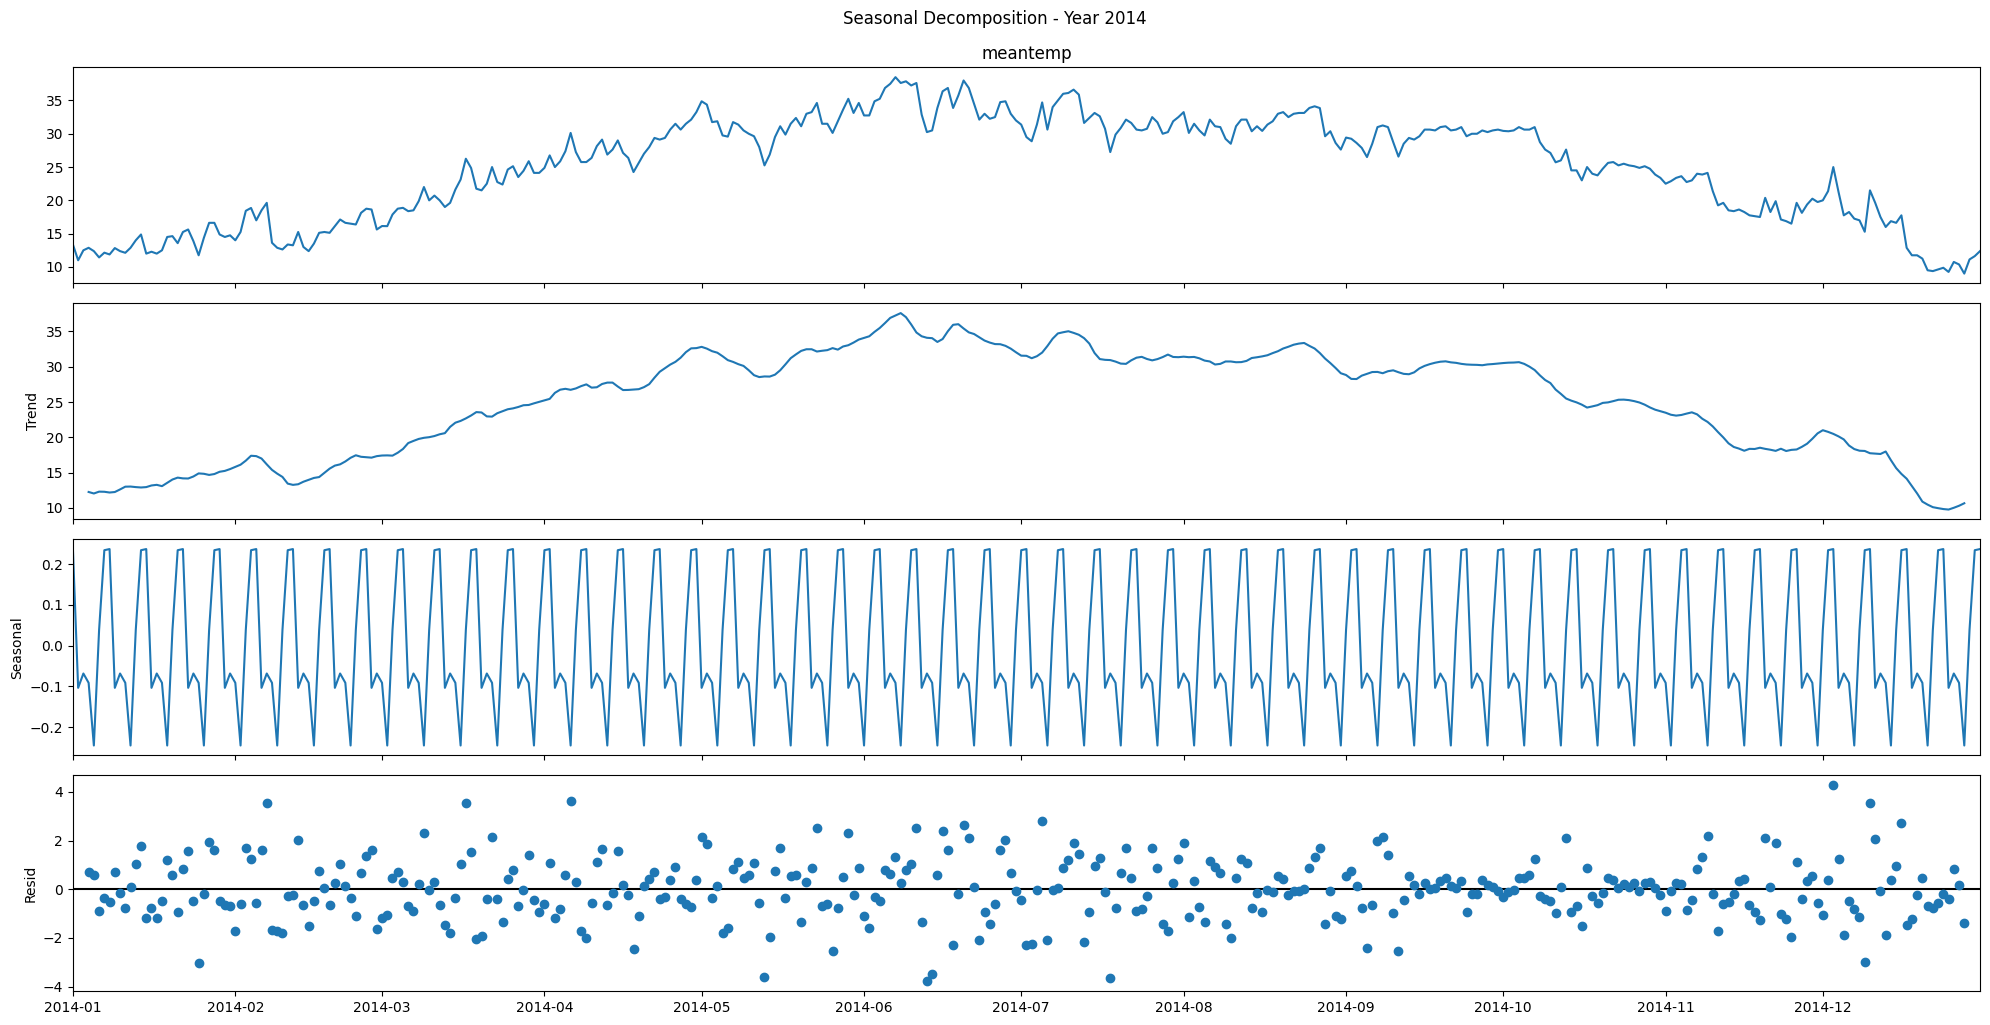

Seasonal decomposition for year 2015:


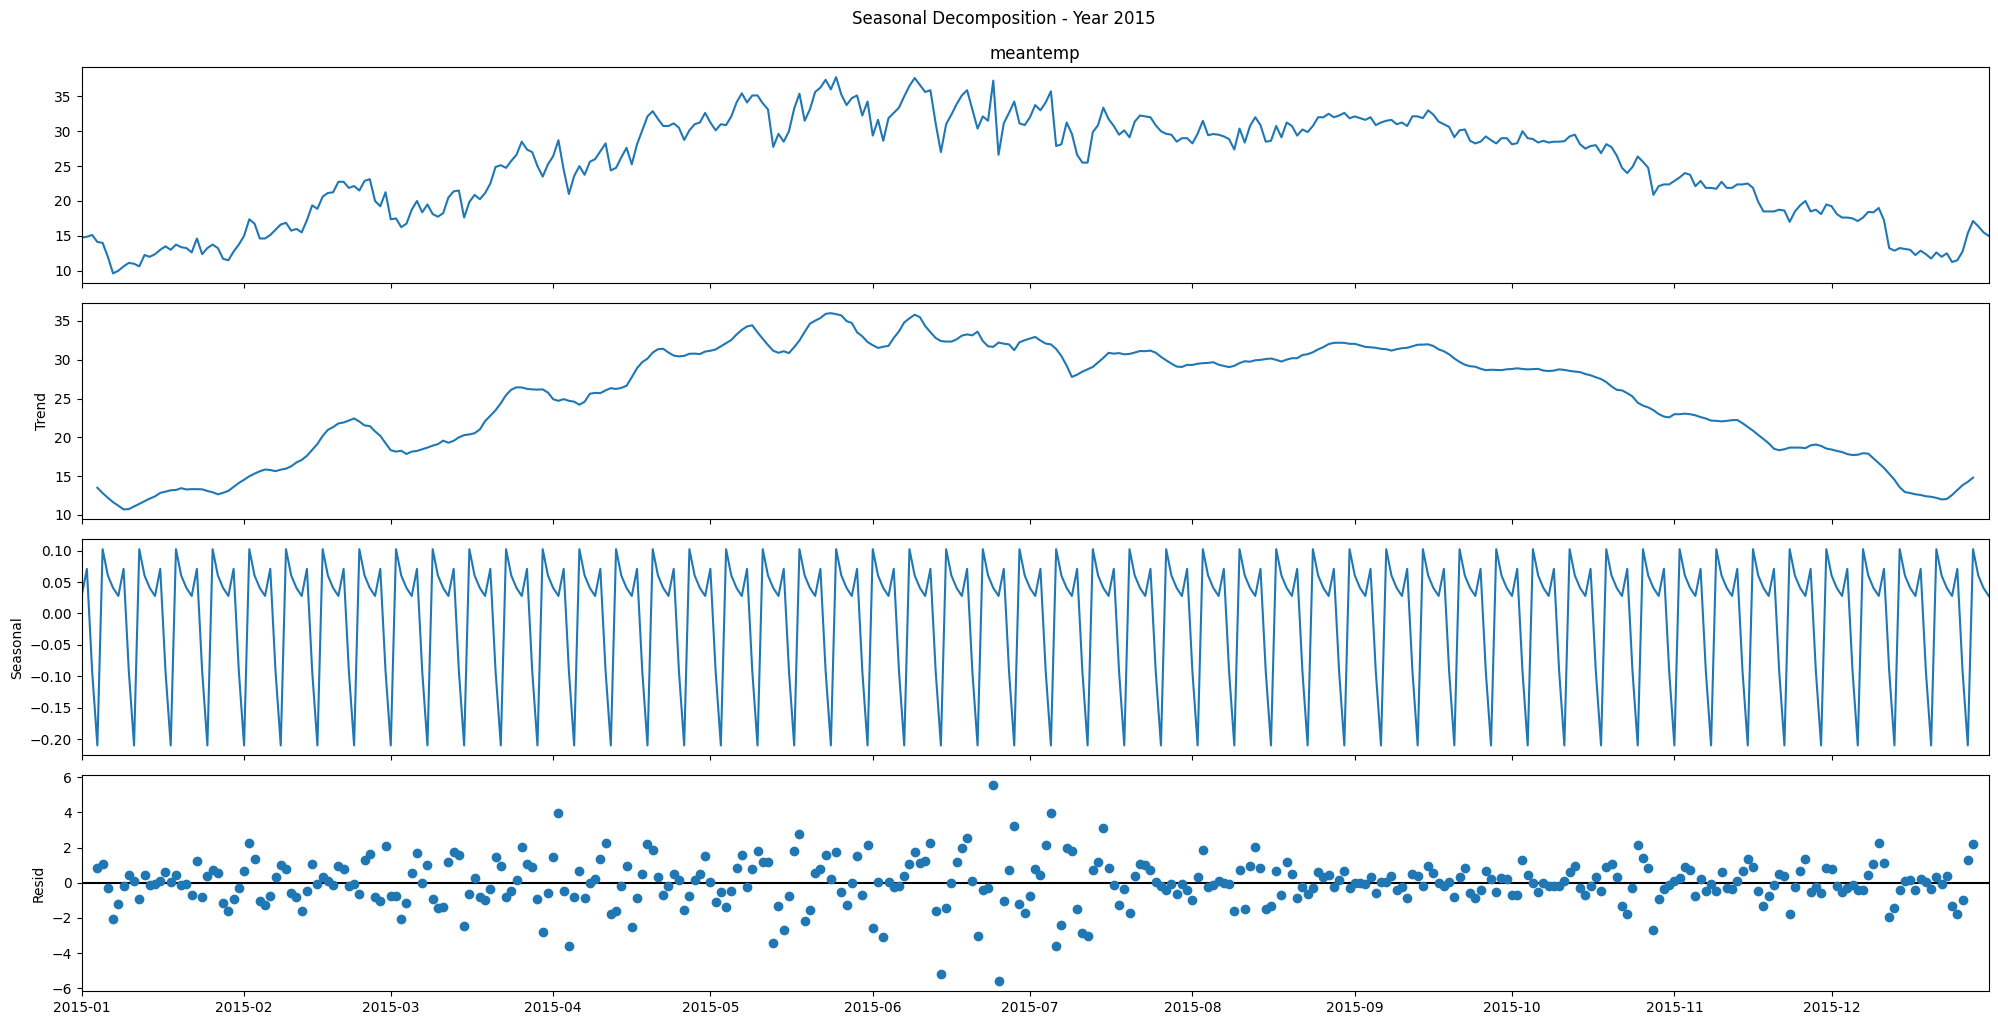

Seasonal decomposition for year 2016:


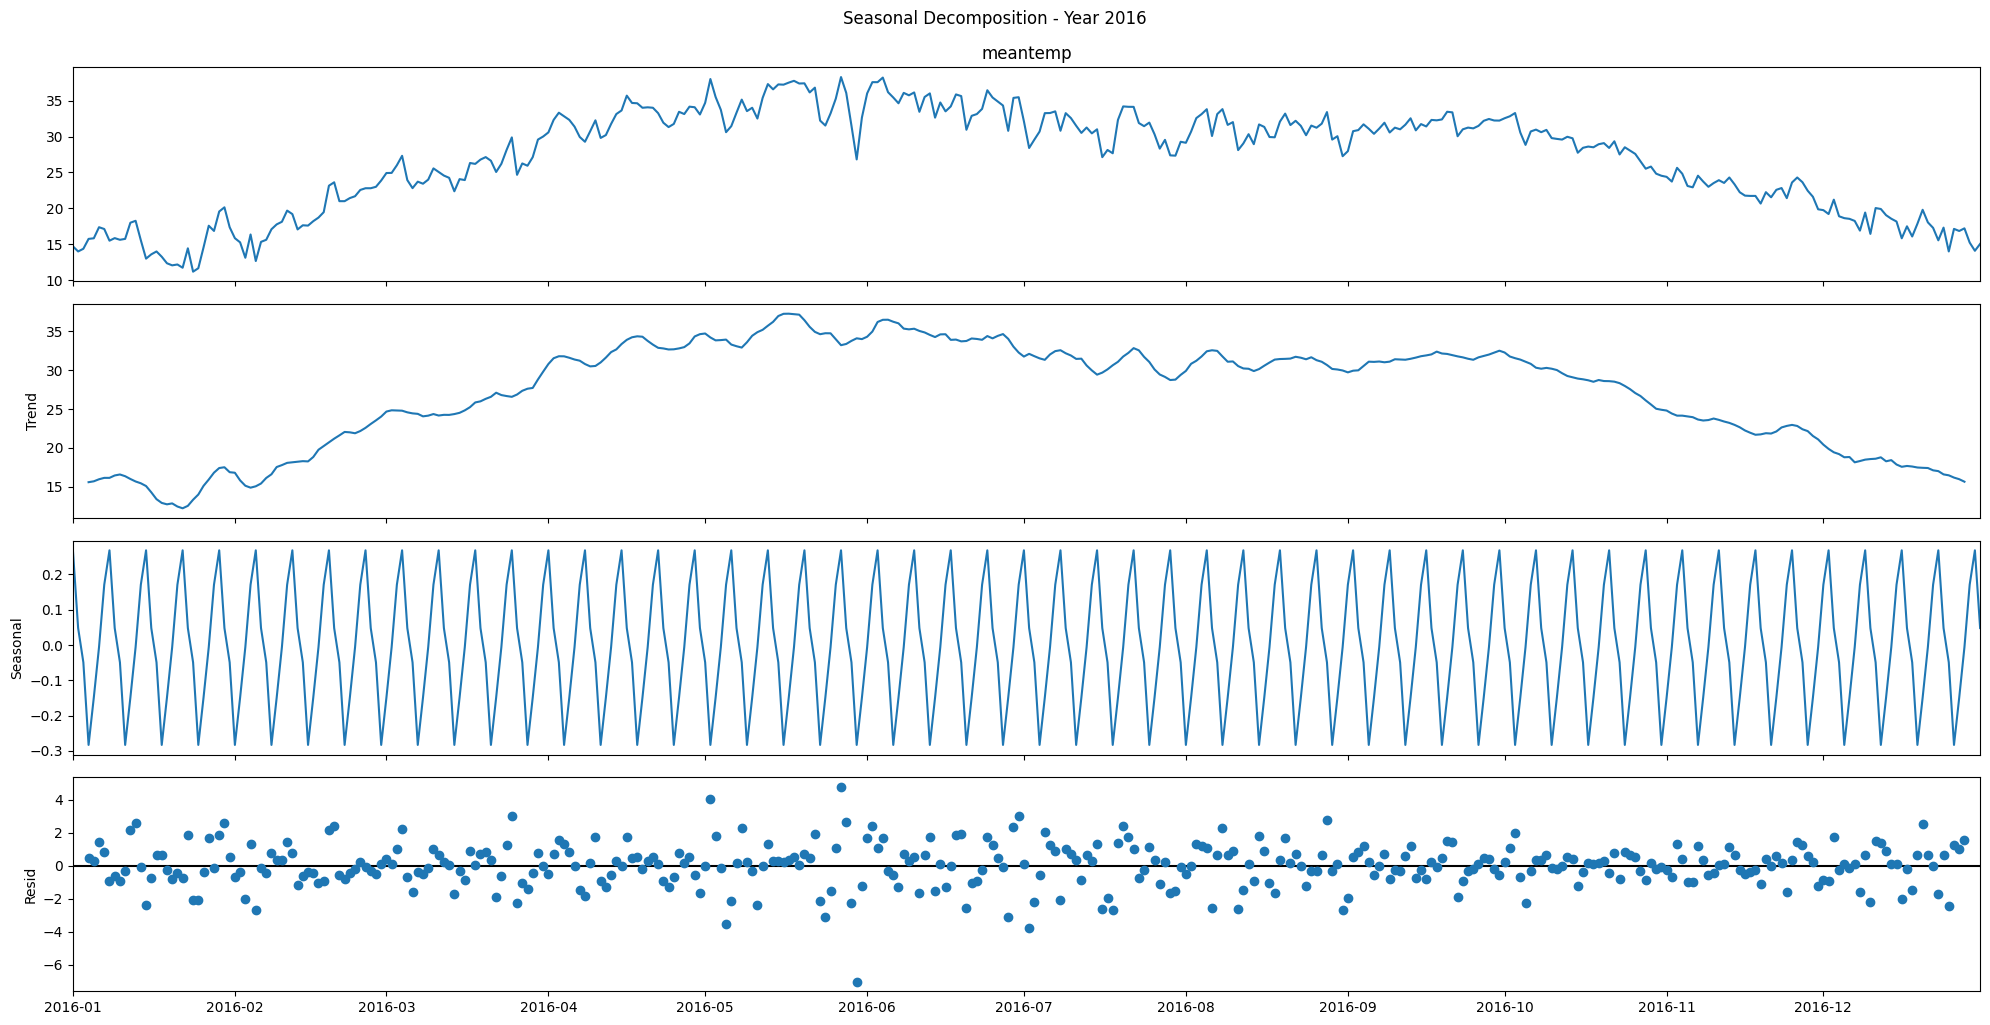

Skipping year 2017 due to insufficient data (1 entries).


In [18]:
for year, group in data.groupby('year'):
    # Ensure the group is sorted by date
    group = group.sort_index()

    # Check if the group has sufficient data for decomposition
    if len(group) < 7:  # Ensure at least 1 week of data
        print(f"Skipping year {year} due to insufficient data ({len(group)} entries).")
        continue

    # Perform seasonal decomposition with a weekly period
    result = seasonal_decompose(group['meantemp'], model='additive', period=7)

    # Plot the results
    print(f"Seasonal decomposition for year {year}:")
    result.plot()
    plt.suptitle(f"Seasonal Decomposition - Year {year}", y=1.02)
    plt.show()


In [19]:
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
# Mean Temperature
fig_temp = go.Figure()
fig_temp.add_trace(go.Scatter(x=data.index, y=data['meantemp'], mode='lines'))
fig_temp.update_layout(title="Mean Temperature", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5)
fig_temp.show()

# Humidity
fig_humidity = go.Figure()
fig_humidity.add_trace(go.Scatter(x=data.index, y=data['humidity'], mode='lines'))
fig_humidity.update_layout(title="Humidity", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5)
fig_humidity.show()

# Wind Speed
fig_wind = go.Figure()
fig_wind.add_trace(go.Scatter(x=data.index, y=data['wind_speed'], mode='lines'))
fig_wind.update_layout(title="Wind Speed", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5)
fig_wind.show()

# Mean Pressure
fig_pressure = go.Figure()
fig_pressure.add_trace(go.Scatter(x=data.index, y=data['meanpressure'], mode='lines'))
fig_pressure.update_layout(title="Mean Pressure", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5)
fig_pressure.show()

In [21]:
# Mean Temperature for 2013
fig_temp_2013 = go.Figure()
fig_temp_2013.add_trace(go.Scatter(x=data.loc['2013', :].index, 
                                   y=data.loc['2013', 'meantemp'], 
                                   mode='lines',
                                   line=dict(color='blue')))  
fig_temp_2013.update_layout(title="Mean Temperature (2013)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)  
fig_temp_2013.show()

# Mean Temperature for 2016
fig_temp_2016 = go.Figure()
fig_temp_2016.add_trace(go.Scatter(x=data.loc['2016', :].index, 
                                   y=data.loc['2016', 'meantemp'], 
                                   mode='lines',
                                   line=dict(color='blue'))) 
fig_temp_2016.update_layout(title="Mean Temperature (2016)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)  
fig_temp_2016.show()

# Humidity for 2013
fig_humidity_2013 = go.Figure()
fig_humidity_2013.add_trace(go.Scatter(x=data.loc['2013', :].index, 
                                       y=data.loc['2013', 'humidity'], 
                                       mode='lines',
                                       line=dict(color='green'))) 
fig_humidity_2013.update_layout(title="Humidity (2013)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)  
fig_humidity_2013.show()

# Humidity for 2016
fig_humidity_2016 = go.Figure()
fig_humidity_2016.add_trace(go.Scatter(x=data.loc['2016', :].index, 
                                       y=data.loc['2016', 'humidity'], 
                                       mode='lines',
                                       line=dict(color='green')))  
fig_humidity_2016.update_layout(title="Humidity (2016)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)
fig_humidity_2016.show()

# Plotting Wind Speed for 2013
fig_wind_2013 = go.Figure()
fig_wind_2013.add_trace(go.Scatter(x=data.loc['2013', :].index, 
                                   y=data.loc['2013', 'wind_speed'], 
                                   mode='lines',
                                   line=dict(color='red')))  
fig_wind_2013.update_layout(title="Wind Speed (2013)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)  
fig_wind_2013.show()

# Wind Speed for 2016
fig_wind_2016 = go.Figure()
fig_wind_2016.add_trace(go.Scatter(x=data.loc['2016', :].index, 
                                   y=data.loc['2016', 'wind_speed'], 
                                   mode='lines',
                                   line=dict(color='red')))  
fig_wind_2016.update_layout(title="Wind Speed (2016)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)  
fig_wind_2016.show()

#Mean Pressure for 2013
fig_pressure_2013 = go.Figure()
fig_pressure_2013.add_trace(go.Scatter(x=data.loc['2013', :].index, 
                                       y=data.loc['2013', 'meanpressure'], 
                                       mode='lines',
                                       line=dict(color='purple')))  
fig_pressure_2013.update_layout(title="Mean Pressure (2013)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)  
fig_pressure_2013.show()

# Mean Pressure for 2016
fig_pressure_2016 = go.Figure()
fig_pressure_2016.add_trace(go.Scatter(x=data.loc['2016', :].index, 
                                       y=data.loc['2016', 'meanpressure'], 
                                       mode='lines',
                                       line=dict(color='purple')))  
fig_pressure_2016.update_layout(title="Mean Pressure (2016)", xaxis_title="Date", yaxis_title="Value", template='plotly_white', title_x=0.5, height=380)  

In [22]:
temp = data['meantemp']
temp.head()

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Name: meantemp, dtype: float64

In [23]:
test_temp = test['meantemp']
test_temp.head()

date
2013-01-01    15.913043
2013-01-02    18.500000
2013-01-03    17.111111
2013-01-04    18.700000
2013-01-05    18.388889
Name: meantemp, dtype: float64

In [24]:
from statsmodels.tsa.ar_model import AutoReg

lag_order = 180
ar_model_wind = AutoReg(temp, lags=lag_order)
model_fit = ar_model_wind.fit()

In [25]:
predictions = model_fit.predict(start=len(temp), end=len(temp)+len(test_temp)-1, dynamic=False)

mse_wind = mean_squared_error(test_temp, predictions)
print(f'Mean Squared Error: {mse_wind:.5f}')
mae_wind = mean_absolute_error(test_temp, predictions)
print(f'Mean Absolute Error: {mae_wind:.5f}')
rmse_wind = mean_squared_error(test_temp, predictions, squared=False)
print(f'Root Mean Squared Error: {rmse_wind:.5f}')

Mean Squared Error: 19.50445
Mean Absolute Error: 3.59048
Root Mean Squared Error: 4.41638


In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_temp.index, y=test_temp, mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(x=test_temp.index, y=predictions, mode='lines+markers', name='Predicted'))

fig.update_layout(title='AR Model Forecasting',
                  xaxis_title='Date',
                  yaxis_title='Mean Temperature',
                  legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='right', x=1),
                  margin=dict(l=50, r=50, t=80, b=50),
                  template='plotly_white',
                  title_x=0.5) 

# Decrease the size of markers
fig.update_traces(marker=dict(size=4))

fig.show()

In [27]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaled = scaler.fit_transform(temp.values.reshape(-1, 1))
test_temp_scaled = scaler.transform(test_temp.values.reshape(-1, 1))

# Create a sliding window
def create_lstm_dataset(data, look_back=180):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 180
X_train, y_train = create_lstm_dataset(temp_scaled, look_back)
X_test, y_test = create_lstm_dataset(np.concatenate((temp_scaled[-look_back:], test_temp_scaled)), look_back)

# Reshape input for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test)

# Calculate metrics
mse_lstm = mean_squared_error(y_test_original, predictions)
mae_lstm = mean_absolute_error(y_test_original, predictions)
rmse_lstm = mean_squared_error(y_test_original, predictions, squared=False)

print(f'Mean Squared Error: {mse_lstm:.5f}')
print(f'Mean Absolute Error: {mae_lstm:.5f}')
print(f'Root Mean Squared Error: {rmse_lstm:.5f}')

# Plot actual vs predicted
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_temp.index[:len(predictions)], y=y_test_original.flatten(), mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(x=test_temp.index[:len(predictions)], y=predictions.flatten(), mode='lines+markers', name='Predicted'))

fig.update_layout(title='LSTM Model Forecasting',
                  xaxis_title='Date',
                  yaxis_title='Mean Temperature',
                  legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='right', x=1),
                  margin=dict(l=50, r=50, t=80, b=50),
                  template='plotly_white',
                  title_x=0.5) 

fig.update_traces(marker=dict(size=4))
fig.show()

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1729
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0058
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0054
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0046
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0044
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0042
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0044
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0040
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0043
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0041
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0039
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0041
Epoch 13/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0039
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0039
Epoch 15/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0039
Epoc